In [51]:
# improts
import pandas as pd
import numpy as np
from numpy import linalg
from scipy.stats import norm
from matplotlib import pyplot as plt
import statsmodels.api as sm
import seaborn as sns
import random

# bootstarp size defined in the question
B = 400

In [52]:
# functions from project 3 that will help us in this project

def extract_X_y(data, X_columns, y_column):
    # create X matrix with first column as bias column
    X = data[X_columns]
    X.insert(loc=0, column="bias", value=[1 for i in range(len(X))])
    X = X.to_numpy()

    # create y vector
    y = data[y_column].to_numpy()

    return X, y

def find_beta_hat(X, y):
    beta_hat = linalg.inv(X.T @ X) @ X.T @ y
    return beta_hat


def find_sum_squares(beta_hat, X, y):
  y_avg = np.mean(y)
  SSR, SSE = 0, 0
  for xi, yi in zip(X, y):
    y_hat = beta_hat.T @ xi
    SSR += (y_hat - y_avg) ** 2
    SSE += (y_hat - yi) ** 2

  SST = SSR + SSE

  return SSR, SSE, SST

In [53]:
# the edited data from project 1
data = pd.read_csv("athletes_edited.csv")
display(data)

,nationality,sport,age,male,height,weight,won_any,won_gold,total_medals
0,ESP,athletics,46,1,172,64,0,0,0
1,KOR,fencing,29,0,168,56,0,0,0
2,CAN,athletics,24,1,198,79,1,0,1
3,MDA,taekwondo,25,1,183,80,0,0,0
4,NZL,cycling,25,1,181,71,0,0,0
...,...,...,...,...,...,...,...,...,...
10853,CUB,athletics,20,0,164,58,0,0,0
10854,CZE,athletics,29,0,173,63,0,0,0
10855,CHN,wrestling,25,1,185,100,0,0,0
10856,VIE,weightlifting,27,1,160,56,0,0,0


# Part 1

## From Project 3:

The explaining variables we chose:
- height (continuous) - represents the height (in cm) of the athlete. This variable has many values, and therefore we can consider it as a continuous variable by the project instructions.

- age (continuous) - represents the age (in years) of the athlete. This variable has many values, and therefore we can consider it as a continuous variable by the project instructions.

- male (discrete) - represents the gender of the athlete. This variable has only two values, 1 if the athlete is male, and 0 if the athlete is female. It is a binary variable and therefore discrete.

The explained variable we chose:
- weight (continuous) - represents the weight (in kg) of the athlete. This variable has many values, and therefore we can consider it as a continuous variable by the project instructions.

### Research question -- Do changes in the variables ('height', 'age', 'male') affect the variable 'weight'?

In [54]:
# same random_state from project 3 in order to get the same sample
sampled_data1 = data.sample(n=200, random_state=0)

X, y = extract_X_y(sampled_data1, X_columns=["height", "age", "male"], y_column="weight")
beta_hat = find_beta_hat(X, y)

beta_conf_intervals = [[] for i in range(len(beta_hat))]

## Q1

In this question, we will find confidence intervals with approximated confidence level of 0.95, for $\beta_j$ for all $0 \le j \le k$ using the following methods:

- Normal approximation with estimator to $\hat \beta$ variance matrix.
- Bootstrap Normal approximation method.
- Bootstrap pivotal method.
- Bootstrap percentile method.

### Section A - Normal approximation with estimator to $\hat \beta$ variance matrix.

In [55]:
_, SSE, _ = find_sum_squares(beta_hat, X, y)
n, p = X.shape

MSE = SSE / (n - p)

beta_hat_var_hat = MSE * linalg.inv(X.T @ X)
z = norm.ppf(0.975)

for i, beta_i_hat in enumerate(beta_hat):
    se_i_hat = beta_hat_var_hat[i][i] ** 0.5
    confidence_interval = np.array([beta_i_hat - (z * se_i_hat), beta_i_hat + (z * se_i_hat)])
    beta_conf_intervals[i].append(confidence_interval)
    
    print(f"Confidence interval for beta_{i}:")
    print(np.round(confidence_interval, 3))
    print()

Confidence interval for beta_0:
[-108.617  -54.244]

Confidence interval for beta_1:
[0.71  1.017]

Confidence interval for beta_2:
[-0.403  0.224]

Confidence interval for beta_3:
[ 3.353 10.425]



### Section B - Bootstrap Normal approximation method

We saw in the lecture that $\hat \beta$ is distributed asymptotically Normal. Therefore, we can use this method.

In [56]:
def find_bootstarp_est_lst(B, data):
    est_lst = []
    for b in range(B):
        # we set random_state in order to get consistent results
        bootstrap_data = data.sample(n=200, replace=True, random_state=b)
        X_bootstrap, y_bootstrap = extract_X_y(bootstrap_data, X_columns=["height", "age", "male"], y_column="weight")
        beta_hat_bootstrap = find_beta_hat(X_bootstrap, y_bootstrap)
        est_lst.append(beta_hat_bootstrap)

    return est_lst

est_lst = find_bootstarp_est_lst(B, sampled_data1)

In [57]:
se_boot = ((sum([x ** 2 for x in est_lst]) / B) - ((sum(est_lst) / B) ** 2)) ** 0.5
z = norm.ppf(0.975)

for i, (beta_i_hat, se_i_boot) in enumerate(zip(beta_hat, se_boot)):
    confidence_interval = np.array([beta_i_hat - (z * se_i_boot), beta_i_hat + (z * se_i_boot)])
    beta_conf_intervals[i].append(confidence_interval)

    print(f"Confidence interval for beta_{i}:")
    print(np.round(confidence_interval, 3))
    print()

Confidence interval for beta_0:
[-111.157  -51.704]

Confidence interval for beta_1:
[0.692 1.036]

Confidence interval for beta_2:
[-0.35  0.17]

Confidence interval for beta_3:
[ 3.451 10.327]



### Section C - Bootstrap pivotal method

We will use the formula we saw at HW5, Q4.

In [58]:
for i, beta_i_hat in enumerate(beta_hat):
    est_i_lst = sorted([x[i] for x in est_lst])
    alpha = 0.05
    
    # 0.025 bootstrap quantile
    low_q = est_i_lst[int((alpha / 2) * B)]
    # 0.975 bootstrap quantile
    high_q = est_i_lst[int((1 - (alpha / 2)) * B)]

    # the forumla we saw in our homework
    confidence_interval = np.array([2 * beta_i_hat - high_q, 2 * beta_i_hat - low_q])
    beta_conf_intervals[i].append(confidence_interval)

    print(f"Confidence interval for beta_{i}:")
    print(np.round(confidence_interval, 3))
    print()

Confidence interval for beta_0:
[-109.057  -51.13 ]

Confidence interval for beta_1:
[0.688 1.028]

Confidence interval for beta_2:
[-0.358  0.177]

Confidence interval for beta_3:
[ 3.72  10.238]



### Section D - Bootstrap percentile method

In [59]:
for i, beta_i_hat in enumerate(beta_hat):
    est_i_lst = sorted([x[i] for x in est_lst])
    alpha = 0.05

    # 0.025 bootstrap quantile
    low_q = est_i_lst[int((alpha / 2) * B)]
    # 0.975 bootstrap quantile
    high_q = est_i_lst[int((1 - (alpha / 2)) * B)]

    confidence_interval = np.array([low_q, high_q])
    beta_conf_intervals[i].append(confidence_interval)

    print(f"Confidence interval for beta_{i} with approximated confidence level of 0.95:")
    print(np.round(confidence_interval, 3))
    print()

Confidence interval for beta_0 with approximated confidence level of 0.95:
[-111.731  -53.804]

Confidence interval for beta_1 with approximated confidence level of 0.95:
[0.7   1.039]

Confidence interval for beta_2 with approximated confidence level of 0.95:
[-0.356  0.179]

Confidence interval for beta_3 with approximated confidence level of 0.95:
[ 3.54  10.058]



## Q2

In [60]:
X_all, y_all = extract_X_y(data, X_columns=["height", "age", "male"], y_column="weight")
beta_hat_all = find_beta_hat(X_all, y_all)

print("The mean least square estimator beta_hat (based on all data):")
print(np.round(beta_hat_all, 3))
print()

methods_lst = ["Normal approximation with variance matrix hat",
               "Bootstrap Normal approximation",
               "Bootstrap pivotal",
               "Bootstrap percentile"]

for i, beta_i_conf_intervals in enumerate(beta_conf_intervals):
    print(f"----- For Beta_{i} -----")
    
    for conf_interval, method in zip(beta_i_conf_intervals, methods_lst):
        l, u = conf_interval
        
        print(f"-- Method: {method} --")
        print(f"Confidence interval length: {round(u - l, 3)}")
        
        if l <= beta_hat_all[i] <= u: 
            print(f"Beta_hat_{i} estimator (based on all data) is trapped in the confidence interval")

        else:
            print(f"Beta hat_{i} estimsator (based on all data) is not trapped in the confidence intreval")
        print()
    print()

The mean least square estimator beta_hat (based on all data):
[-101.834    0.945    0.145    5.662]

----- For Beta_0 -----
-- Method: Normal approximation with variance matrix hat --
Confidence interval length: 54.373
Beta_hat_0 estimator (based on all data) is trapped in the confidence interval

-- Method: Bootstrap Normal approximation --
Confidence interval length: 59.453
Beta_hat_0 estimator (based on all data) is trapped in the confidence interval

-- Method: Bootstrap pivotal --
Confidence interval length: 57.927
Beta_hat_0 estimator (based on all data) is trapped in the confidence interval

-- Method: Bootstrap percentile --
Confidence interval length: 57.927
Beta_hat_0 estimator (based on all data) is trapped in the confidence interval


----- For Beta_1 -----
-- Method: Normal approximation with variance matrix hat --
Confidence interval length: 0.307
Beta_hat_1 estimator (based on all data) is trapped in the confidence interval

-- Method: Bootstrap Normal approximation --
C

Summarizing the results:

### *$\beta_0$*
All the confidence intervals lengths are roughly the same, however:
- The shortest confidence interval length is under the "Normal approximation with variance matrix hat" method (54.373).
- The longest confidence interval length is under the "Bootstrap Normal approximation" method (59.453).
  
The confidence intervals under all the methods trapped $\hat \beta_0$ (based on all data).


### $\beta_1$
All the confidence intervals lengths are roughly the same, however:
- The shortest confidence interval length is under the "Normal approximation with variance matrix hat" method (0.307).
- The longest confidence interval length is under the "Normal approximation method" method (0.344).

The confidence intervals under all the methods trapped $\hat \beta_1$ (based on all data).


### $\beta_2$
All the confidence intervals lengths are roughly the same, however:
- The shortest confidence interval length is under the "Bootstrap Normal approximation" method (0.52).
- The longest confidence interval length is under the "Normal approximation with variance matrix hat" method (0.628).
  
The confidence intervals under all the methods trapped $\hat \beta_2$ (based on all data).


### $\beta_3$
All the confidence intervals lengths are roughly the same, however:
- The shortest confidence interval length is under the "Bootstrap pivotal" and "Bootstrap percentile" methods (6.519).
- The longest confidence interval length is under the "Normal approximation with variance matrix hat" method (7.073).
  
The confidence intervals under all the methods trapped $\hat \beta_3$ (based on all data).

## Q3

In [61]:
# sample 100 new records that are not in 'sampled data1' (as stated)
# we set random_state in order to get consistent results
sampled_indecies = sampled_data1.index.values
data_without_sampled = data.drop(sampled_indecies, axis=0)
new_sampled_data = data_without_sampled.sample(n=100, random_state=0)

X_new_sampled, y_new_sampled = extract_X_y(new_sampled_data, X_columns=["height", "age", "male"], y_column="weight")

### Section A

In [62]:
# vector of the predicated y value of each sample
y_predicted = X_new_sampled @ beta_hat

### Section B

In order to find the confidence intervals, we will use the bootstrap percentile method.

In [63]:
# the confidence level is 0.95
alpha = 0.05

confidence_interval_lst = []

for x_new in X_new_sampled:
    y_new_pred_bootstrap_lst = []

    for beta_hat_bootstrap in est_lst:
        y_new_pred_bootstrap_lst.append(beta_hat_bootstrap.T @ x_new)

    y_new_pred_bootstrap_lst.sort()
    low_q = y_new_pred_bootstrap_lst[int((alpha / 2) * B)]
    high_q = y_new_pred_bootstrap_lst[int((1 - (alpha / 2)) * B)]
    confidence_interval_lst.append([low_q, high_q])



### Section C

In [87]:
summ = 0
for ci, y_new in zip(confidence_interval_lst, y_new_sampled):
    l, u = ci

    if l <= y_new <= u:
        summ += 1

trap_per = summ / len(y_new_sampled) * 100

print(f"The percentage of the confidence intervals that trap y_new is: {round(trap_per, 3)}%")

The percentage of the confidence intervals that trap y_new is: 29.0%


As we see, our confidence intervals trapped y_new 29% of the time. This result doesn't contradict our defined 95% approximated confidence level since our confidence intervals were for the expected value of y_new and not for the value itself.

### Section D


In this question, we are asked to find confidence intervals for each 'y_new'.

As we saw in the tutorial, we need to add the model's assumption that the noise of each sample $\epsilon$ is distributed Normally.
Under this assumption, each y value is distributed Normally as well. Moreover, we saw in the lecture that $\hat \beta$ is distributed asymptotically Normally. Therefore, we can use the bootstrap Normal approximation method in order to find the wanted confidence intervals.

As we saw in the tutorial, the s.e. of the wanted confidence interval is $\sqrt{X_{new}^T Var(\hat \beta) X_{new} + \sigma^2_\epsilon}$ (*)

We can estiamte $\sigma^2_\epsilon$ with $\hat \sigma^2_\epsilon$ using the initial given data (MSE) and $X_{new}$ is given. Therefore, all that's left to do is to estimate $Var(\hat \beta)$ 

In order to do it, we will find the bootstrap estimator as done in question 2, section B (we showed there how to find the wanted bootstrap estimator).

After finding $\hat Var(\hat \beta)_{boot}$, we can find $s.e._{boot}$ by using (*).

The confidence interval for each 'y_new' will be in the following form (as seen in the lecture):

$\hat \beta^T X_{new} \pm z_{\alpha / 2} * s.e._{boot}$

# Part 2

## From project 2

"The research question we chose for this part:

**Does the average weight (X) of the athletes change between the athletes who won a medal (Y=1) and the ones who didn't (Y=0)?**"

## Q1

The research question we chose for this project:

**Is the athletes' weight who won a medal larger than the athletes' weight who didn't win any medals, in the "usual stochastic order"?**

(The probability of an athlete who won a medal to have a large weight is higher than the probability of an athlete didn't win any medals to have the same large weight value).

## Q2

In [65]:
# set random_state in order to get consistent results (different from part 1)
sampled_data2 = data.sample(n=200, random_state=1)

## Q3

Notations:

- Let $\mu_x^1$ be the expectation of athletes' weight who won a medal.

- Let $\mu_x^2$ be the expectation of athletes' weight who didn't win any medals.

### Section A

We will choose the following estimators:
- $\hat \mu_x^1 = \bar X_1$
- $\hat \mu_x^2 = \bar X_2$
- $\hat \delta = \bar X_1 - \bar X_2$

If the weights' values of each group are distributed Normally, we saw in the lecture that $\bar X_1$ and $\bar X_2$ are MLEs of $\mu_x^1$ and $\mu_x^2$ correspondingly. Therefore, $\hat \delta$ is an MLE of $\delta$ as a function of $\bar X_1$ and $\bar X_2$. We will check if the weights are indeed distributed Normally.

In [100]:
def create_histogram(data, bins, x_label, title, is_kde=True, c="royalblue"):
    sns.histplot(data, bins=bins, kde=is_kde, color=c)

    plt.xlabel(x_label)
    plt.ylabel("Count")
    plt.title(title)
    plt.show()

def abline(slope, intercept, style):
    axes = plt.gca()
    x_vals = np.array(axes.get_xlim())
    y_vals = intercept + slope * x_vals
    plt.plot(x_vals, y_vals, style, c="r")


def create_qq_plot(data):
    n = len(data)
    data_sorted = sorted(data)
    mu_hat = data.mean()
    se_hat = data.std()
    theo_q = [norm.ppf((i - 0.5) / n, mu_hat, se_hat) for i in range(1, n+1)]

    plt.scatter(theo_q, data_sorted, c="royalblue")
    plt.title("Q-Q Plot")
    plt.xlabel("Theortical Quantiles")
    plt.ylabel("Sample Quantiles")
    
    abline(1, 0, "--")
    plt.show()

First, we will check if the weights of the first group are distributed Normally.

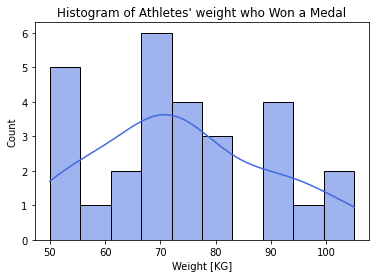

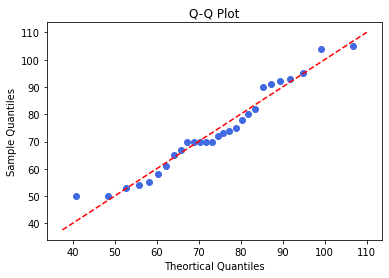

In [98]:
weights_1 = sampled_data2[sampled_data2["won_any"] == 1]["weight"]
n = len(weights_1)

x_label = "Weight [KG]"
title = "Histogram of Athletes' weight who Won a Medal"
create_histogram(weights_1, 10, x_label, title)
create_qq_plot(weights_1)


As we can see, the distribution above does not resemble a normal distribution. In addition, we checked for normality using a Q-Q plot, which also does not indicate normality of our data.

Now, we'll checking if the weights of the second group are distributed Normally.

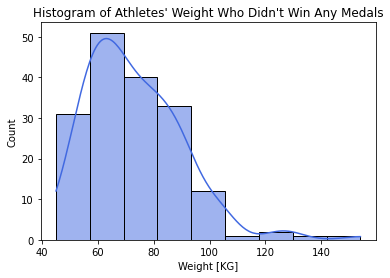

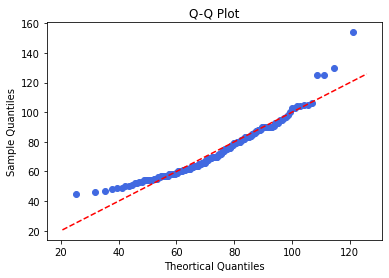

In [99]:
weights_2 = sampled_data2[sampled_data2["won_any"] == 0]["weight"]
m = len(weights_2)

x_label = "Weight [KG]"
title = "Histogram of Athletes' Weight Who Didn't Win Any Medals"
create_histogram(weights_2, 9, x_label, title)
create_qq_plot(weights_2)

As we can see, the distribution above does not resemble a normal distribution. In addition, we checked for normality using a Q-Q plot, which also does not indicate normality of our data.

It seems that the data doesn't come from a known distribution. Therefore, we don't have the density function of the data and as a result, we can't find the likelihood function. Thus, it's irrelevant to talk about MLE.

(*) In order to check if the data comes from a known distribution, we were instructed in an office hour to only check if the data is distributed Normally.

Findings the estimators.

In [69]:
mu_1_hat = weights_1.mean()
mu_2_hat = weights_2.mean()

delta_hat = mu_1_hat - mu_2_hat

print(f"The estimator of mu_1 (based on sampled_data2): {round(mu_1_hat, 3)}")
print(f"The estimator of mu_2 (based on sampled_data2): {round(mu_2_hat, 3)}")
print(f"The estimator of delta (based on sampled_data2): {round(delta_hat, 3)}")

The estimator of mu_1 (based on sampled_data2): 73.821
The estimator of mu_2 (based on sampled_data2): 73.215
The estimator of delta (based on sampled_data2): 0.606


### Section B

Notations:

- Let ${\sigma_x^1}^2$ be the variance of the athletes' weight who won a medal.
- Let $n$ be the athletes number who won a medal.
- Let ${\sigma_x^2}^2$ be the variance of the athletes' weight who didn't win any medals.
- Let $m$ be the athletes number who didn't win any medal.


According to project 2, question 1, section b, we can assume that $\bar X_1 \approx N(\hat \mu_x^1, \space {\sigma_x^1}^2/n)$, $\bar X_2 \approx N(\hat \mu_x^2, \space {\sigma_x^2}^2/m)$.

Since the samples of our data are independent, we can assume that $\hat \delta = \bar X_1 - \bar X_2 \approx N(\hat \mu_x^1 - \hat \mu_x^2, \space ({\sigma_x^1}^2 / n) + ({\sigma_x^2}^2 / m))$.

As a result, we can find a confidence interval using normal approximation (with estimation of the variance).

In [70]:
mean_s1_squared = weights_1.var() / n
mean_s2_squared = weights_2.var() / m

se_hat = (mean_s1_squared + mean_s2_squared) ** 0.5
z = norm.ppf(0.975)

confidence_interval = np.array([delta_hat - (z * se_hat), delta_hat + (z * se_hat)])
print(f"Confidence interval with approximated confidence level of 0.95 for delta: {np.round(confidence_interval, 3)}")

Confidence interval with approximated confidence level of 0.95 for delta: [-5.756  6.969]


### Section C

In [71]:
mu_1_all_hat = data[data["won_any"] == 1]["weight"].mean()
mu_2_all_hat = data[data["won_any"] == 0]["weight"].mean()
delta_all_hat = mu_1_all_hat - mu_2_all_hat
print(f"The estimator of delta (based on all data): {round(delta_all_hat, 3)}")

The estimator of delta (based on all data): 3.076


As we can see, the estimator of delta (based on all the data) is indeed trapped in the confidence interval we found in the previous section.

### Section D

In this section, we will use the following tests with level $\alpha = 0.05$ (in each one), in order to check our research question

- Wald test.
- Permutation test.

### Wald test

We will use this test in order to check the following hypotheses:

$H_0: \delta = 0 $

$H_1: \delta > 0$

$T.S$: $W = (\hat \delta - \delta) / \hat {s.e}$

$R.R$: $W > z_{\alpha}$

(*) We are using the one-sided version of this test since our research question is one-sided.

(**) We showed that $\hat \delta$ is asymptotically normal, therefore we can use this test.

In [72]:
W = delta_hat / se_hat

# the 0.95 quantile of standard normal distribution
nq = norm.ppf(0.95)

# the reject region
reject_h0 = W > nq

if reject_h0:  
    print(f"The result of our test is --- Reject H_0")
else:
    print(f"The result of the test is --- Retain H_0")

pv = 1 - norm.cdf(W)

print(f"PV: {round(pv, 3)}")

The result of the test is --- Retain H_0
PV: 0.426


### Permutation test

We will use this test in order to check the following hypotheses:

$H_0: F_{X_1} = F_{X_2}$

$H_1: F_{X_1} \succ F_{X_2}$

T.S: $T_0 = \hat \delta$

p-value: $(\#I [T_j \ge T_0]) / B$

R.R: $PV < \alpha$

(*) We generated B permutations according to the question instructions.

In [73]:
# generate permutations B according to the question instructions
def generate_permutations(data, n, B):
    permutations_1, permutations_2 = [], []

    for b in range(B):
        # sampling values without repetition
        data_copy = data.copy()
        sampled_data = data_copy.sample(n=n, random_state=b)
        sampled_indecies = sampled_data.index.values
        data_without_sampled = data_copy.drop(sampled_indecies, axis=0)

        permutations_1.append(sampled_data["weight"].values.tolist())
        permutations_2.append(data_without_sampled["weight"].values.tolist())

    return permutations_1, permutations_2

# find B (400) permutations
permutations_1, permutations_2 = generate_permutations(sampled_data2, n, B)

In [74]:
# find delta_hat for each permutations pair
permutation_delta_hat_lst = [(sum(p1) / n) - (sum(p2) / m) for p1, p2 in zip(permutations_1, permutations_2)]

# find the p_value
p_value = sum([1 if per_delta_hat >= delta_hat else 0 for per_delta_hat in permutation_delta_hat_lst]) / len(permutation_delta_hat_lst)

alpha = 0.05
# the reject region
reject_h0 = p_value < alpha

if reject_h0:  
    print(f"The result of our test is --- Reject H_0")
else:
    print(f"The result of the test is --- Retain H_0")

print(f"PV: {p_value}")

The result of the test is --- Retain H_0
PV: 0.48


As we can see, we retain the null hypothesis on both tests, with level $\alpha = 0.05$ (in each one).

## Q4

### Section A

Notations:

- Let $m_1$ be the theoretical median of the distribution of athletes' weights who won a medal.
- Let $m_2$ be the theoretical median of the distribution of athletes' weights who didn't win a medal.

We will choose the following estimators:
- $\hat m_1 = X_{(n/2)}$
- $\hat m_2 = X_{(n/2)}$
- $\hat \delta = \hat m_1 -\hat m_2$

As mentioned in question 3, section A, It seems that the data doesn't come from a known distribution. Therefore, we don't have the density function of the data and as a result, we can't find the likelihood function. Thus, it's irrelevant to talk about MLE.

As we can see, the number of records under each category is even, therefore we can find the median of each sample by taking the $\frac{n}{2}$'th order statistic.

In [75]:
print(f"athelets' number who won a medal: {n}")
print(f"athelets' number who didn't win any medals: {m}")

athelets' number who won a medal: 28
athelets' number who didn't win any medals: 172


Finding the estimators.

In [76]:
weights_1_sorted = sorted(weights_1)
weights_2_sorted = sorted(weights_2)

m1_hat = weights_1_sorted[n // 2]
m2_hat = weights_2_sorted[m // 2]
delta_hatt = m1_hat - m2_hat

print(f"The estimator of m1 (based on sampled_data2): {round(m1_hat, 3)}")
print(f"The estimator of m2 (based on sampled_data2): {round(m2_hat, 3)}")
print(f"The estimator of delta (based on sampled_data2): {round(delta_hatt, 3)}")

The estimator of m1 (based on sampled_data2): 72
The estimator of m2 (based on sampled_data2): 70
The estimator of delta (based on sampled_data2): 2


### Section B

In this section, we will find a confidence interval for $\hat \delta$, using the bootstrap percentile method with approximated confidence level of 0.95.

In [77]:
def generate_bootstrap_estimators(weights_1, weights_2, B):
    n, m = len(weights_1), len(weights_2)
    bs_delta_estimators = []

    for b in range(B):
        # create bootstrap sample of each group
        # # we set random_state in order to get consistent results
        bs_weights_1 = sorted(weights_1.sample(n=n, random_state=b, replace=True))
        bs_weights_2 = sorted(weights_2.sample(n=m, random_state=b, replace=True))

        # find the bootstrap mean of each group
        bs_m1 = bs_weights_1[n // 2]
        bs_m2 = bs_weights_2[m // 2]

        # find the bootstrap estimator delta_hat
        bs_delta = bs_m1 - bs_m2
        bs_delta_estimators.append(bs_delta)

    return bs_delta_estimators

bootstrap_est_lst = generate_bootstrap_estimators(weights_1, weights_2, B)

In [78]:
bootstrap_est_lst_sorted = sorted(bootstrap_est_lst)

# 0.025 and 0.975 bootstrap percentiles
alpha = 0.05
low_q = bootstrap_est_lst_sorted[int((alpha / 2) * B)]
high_q = bootstrap_est_lst_sorted[int((1 - (alpha / 2)) * B)]

confidence_interval = np.array([low_q, high_q])
print("Confidence interval:")
print(confidence_interval)

Confidence interval:
[-4 11]


### Section C

In [79]:
# the median of each group based on all the data
m1_all_hat = int(data[data["won_any"] == 1]["weight"].median())
m2_all_hat = int(data[data["won_any"] == 0]["weight"].median())

delta_all_hatt = m1_all_hat - m2_all_hat
print(f"The estimator of delta (based on all data): {round(delta_all_hatt, 3)}")

The estimator of delta (based on all data): 4


As we can see, the estimator of delta (based on all the data) is indeed trapped in the confidence interval we found in the previous section.

### Section D

In this section, we will use permutation test with level $\alpha = 0.05$ in order to check our hypotheses:

$H_0: F_{X_1} = F_{X_2}$

$H_1: F_{X_1} \succ F_{X_2}$

T.S: $T_0 = \hat \delta$

PV: $(\#I [T_j \ge T_0]) / B$

R.R: $PV < \alpha$

(*) We generated B permutations according to the question instructions.

In [80]:
# find B (400) permutations
permutations_1, permutations_2 = generate_permutations(sampled_data2, n, B)

In [81]:
# find delta_hat for each permutations pair
permutation_delta_hatt_lst = [sorted(p1)[n // 2] - sorted(p2)[m // 2] for p1, p2 in zip(permutations_1, permutations_2)]

# find the p_value
p_value = sum([1 if per_delta_hatt >= delta_hatt else 0 for per_delta_hatt in permutation_delta_hatt_lst]) / len(permutation_delta_hatt_lst)

# the reject region
reject_h0 = p_value < alpha
alpha = 0.05

if reject_h0:  
    print(f"The result of our test is --- Reject H_0")
else:
    print(f"The result of the test is --- Retain H_0")

print(f"PV: {p_value}")

The result of the test is --- Retain H_0
PV: 0.48


As we can see, we retain the null hypothesis with level $\alpha = 0.05$

### Section E

#### Using Wald test

As we saw in the lecture, in order to use Wald test, the estimator has to be asymptotically Normal. $\hat \delta$ is the difference between the sample medians and therefore does not necessarily have that property.

We will check if $\hat \delta$ satisfies this condition, using bootstrap.

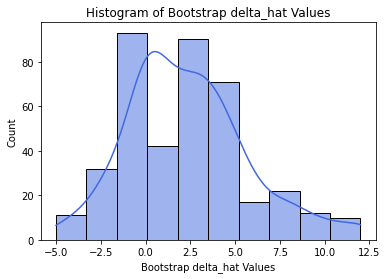

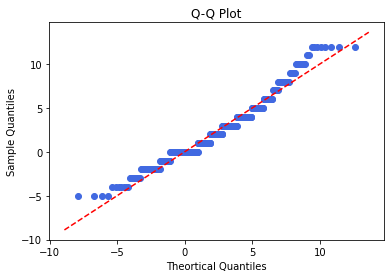

In [82]:
x_label = "Bootstrap delta_hat Values"
title = "Histogram of Bootstrap delta_hat Values"
create_histogram(bootstrap_est_lst, 10, x_label, title)
create_qq_plot(np.array(bootstrap_est_lst))

As we can see from the plots above, the distribution of the bootstrap estimators we received doesn't seem to be Normal. Therefore, it is very unlikely that $\hat \delta$ is asymptotically normal. As a result we can't use Wald test.

#### Using T test

In order to use T test, there are a few conditions that the data has to satisfy. One of them is that the samples under each category are distributed Normally.

As seen in question 3, section A, the values of each group aren't distributed Normally. Therefore, we can't use T test (our data doesn't meet the test conditions).

As we saw in question question 3, section A, the data under each category doesn't seem to be distributed Normally (especially the values under the second category). Therefore, we can't use T test.

## Q5

Notation:

- Let $S_1$ be the rank sum in the first category (Y=0).
- Let $S_2$ be the rank sum in the second category (Y=1).

In this question, we will use permutation test with level $\alpha = 0.05$ in order to check our hypotheses:

$H_0: F_{X_1} = F_{X_2}$

$H_1: F_{X_1} \succ F_{X_2}$

T.S: $T_0 = S_1$

PV: $(\#I [T_j \ge T_0]) / B$

R.R: $PV < \alpha$

(*) This test is basically Wilcoxon test (as seen in the tutorial).

(**) There are duplicated values in our data. We will deal with it in "find_ranks" function implemented below (according to the same principles we saw in the tutorial).

(***) We generated B permutations according to the question instructions.

In [83]:
VALUE, GROUP, RANK = 0, 1, 2

# this function finds the rank of each value according to the principles we saw in the tuorial (regarding duplicated values)
def find_ranks(lst):
    tr_lst = []
    rank_sum, cnt, n = 0, 1, len(lst)
    for i in range(n - 1):

        rank_sum += i+1
        
        if lst[i][VALUE] == lst[i+1][VALUE]:
            cnt += 1
                
        else:
            for j in range(i-cnt+1, i+1):
                lst[j][RANK] = rank_sum / cnt

            if cnt > 1:
                tr_lst.append(cnt)

            rank_sum = 0
            cnt = 1
    
    if cnt > 1:
        tr_lst.append(cnt)

    rank_sum += n
    for j in range(n - cnt, n):
            lst[j][RANK] = rank_sum / cnt
        
    s1 = sum(x[RANK] if x[GROUP] == 1 else 0 for x in lst)
    return s1, tr_lst


def generate_rank_permutations(data, n, B):
    per_1_lst, per_2_lst = generate_permutations(data, n, B)
    s1_permutations = []
    for per_1, per_2 in zip(per_1_lst, per_2_lst):

        per_1 = [[val, 1, 0] for val in per_1]
        per_2 = [[val, 2, 0] for val in per_2]

        total_per = sorted(per_1 + per_2, key=lambda x: x[VALUE])
        s1_per, _ = find_ranks(total_per)

        s1_permutations.append(s1_per)

    return s1_permutations


s1_lst = generate_rank_permutations(sampled_data2, n, B)

In [84]:
# find s1_0 (the rank sum of our data)
weights_1_modified = [[x, 1, 0] for x in weights_1]
weights_2_modified = [[x, 2, 0] for x in weights_2]

all_weights = sorted(weights_1_modified + weights_2_modified, key=lambda x:x[0])
s1_0, tr_0_lst = find_ranks(all_weights) 


# find the p_value
p_value = sum([1 if per_s1 >= s1_0 else 0 for per_s1 in s1_lst]) / len(s1_lst)
alpha = 0.05

# the reject region
reject_h0 = p_value < alpha

if reject_h0:  
    print(f"The result of our test is --- Reject H_0")
else:
    print(f"The result of the test is --- Retain H_0")

print(f"PV: {round(p_value, 3)}")

The result of the test is --- Retain H_0
PV: 0.352


As we can see, we retain the null hypothesis, with level $\alpha = 0.05$.

We saw in the lecture that $S_1$ is asymptotically normal. As mentioned, $n=28, m=172$, therefore, we can use the normal approximation (according to the rule of thumb we saw in the tutorial).

In [85]:
# find S1_0 expcation and variance
N = n + m

tr_sum = sum([(tr * (tr**2 - 1)) for tr in tr_0_lst])

s1_0_mu = (n*(N + 1)) / 2
s1_0_se = (((n*m*(N+1)) / 12) - (((n*m) / (12*N*(N-1))) * tr_sum)) ** 0.5

# test statistic - distributed standard normal
TS = (s1_0 - s1_0_mu) / s1_0_se

# the 0.95 quantile of standard normal distribution
z = norm.ppf(0.95)

# reject region (one sided-test)
reject_h0 = TS > z

if reject_h0:  
    print(f"The result of our test is --- Reject H_0")
else:
    print(f"The result of the test is --- Retain H_0")

print(f"PV: {round(TS, 3)}")

The result of the test is --- Retain H_0
PV: 0.472


As we can see, we retain the null hypothesis, with level $\alpha = 0.05$.

To conclude, we retain the null hypothesis on both tests with level $\alpha = 0.05$ (in each one). However, we received different P-values in each one.

- In the first test, we received $PV = 0.352$
- In the second test, we received $PV = 0.472$

## Q6

All the results we got in questions 3-5 were consistent and pointed to the same conclusion -- to retain the null hypothesis.

This means that $F_{X_1} = F_{X_2}$, or in other words, that the athletes' weight who won a medal is equal to the athletes' weight who didn't win any medals, in the "usual stochastic order".

We will discuss these results after showing a histogram of each group values based on all the data (these histograms are identical to the ones from project 2).


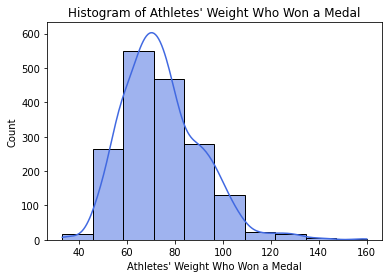

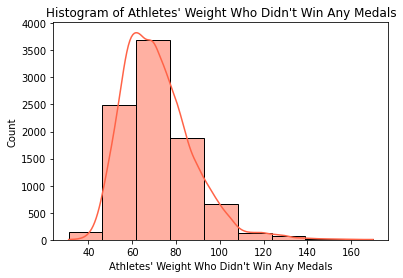

In [101]:
won_weights = data[data["won_any"] == 1]["weight"]
x_label = "Athletes' Weight Who Won a Medal"
title = "Histogram of Athletes' Weight Who Won a Medal"
create_histogram(won_weights, 10, x_label, title)

not_won_weights = data[data["won_any"] == 0]["weight"]
x_label = "Athletes' Weight Who Didn't Win Any Medals"
title = "Histogram of Athletes' Weight Who Didn't Win Any Medals"
create_histogram(not_won_weights, 9, x_label, title, c="tomato")

We can see the following: 

- Both histograms are around the same values range.
- Both histograms have approximately the same common value.
- The distributions of the values under each group are roughly the same.

Therefore, we can conclude that it's reasonable to assume that the distribution of the athletes' weight who won a medal is the same as the distribution of the athletes' weight who didn't win any medals.

Thus, it seems that the test results we got get along with the histograms of the values under each group, and that the null hypothesis is indeed correct.